## DM-15081: Reprocessing HiTS2015 dataset with slurm

In this notebook, we make some plots of a full HiTS2015 data reprocessing run via slurm on lsst-dev.

It worked!! This takes a few hours to process the entire dataset verses several days when not run in parallel.
We make sure to run each CCD in parallel rather than each visit in order to preserve temporality.

The templates need improving still, which is known.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import sqlite3
from astropy.time import Time

from lsst.daf.base import DateTime
import lsst.afw.image as afwImage
import lsst.daf.persistence as dafPersist
import lsst.geom

repoOrig = '/project/mrawls/hits2015/rerun/slurm6'
#repoDcr = '/project/mrawls/hits2015/rerun/dcr1'  # placeholder for future DCR comparison

In [2]:
butler = dafPersist.Butler(repoOrig)

In [3]:
sqliteFile = 'association.db'
connection = sqlite3.connect(os.path.join(repoOrig, sqliteFile))

tables = {'obj': 'dia_objects', 'src': 'dia_sources', 'ccd': 'CcdVisit'}

objTableOrig = pd.read_sql_query('select * from {0};'.format(tables['obj']), connection)
srcTableOrig = pd.read_sql_query('select * from {0};'.format(tables['src']), connection)
ccdTableOrig = pd.read_sql_query('select * from {0};'.format(tables['ccd']), connection)

connection.close()

<IPython.core.display.Javascript object>


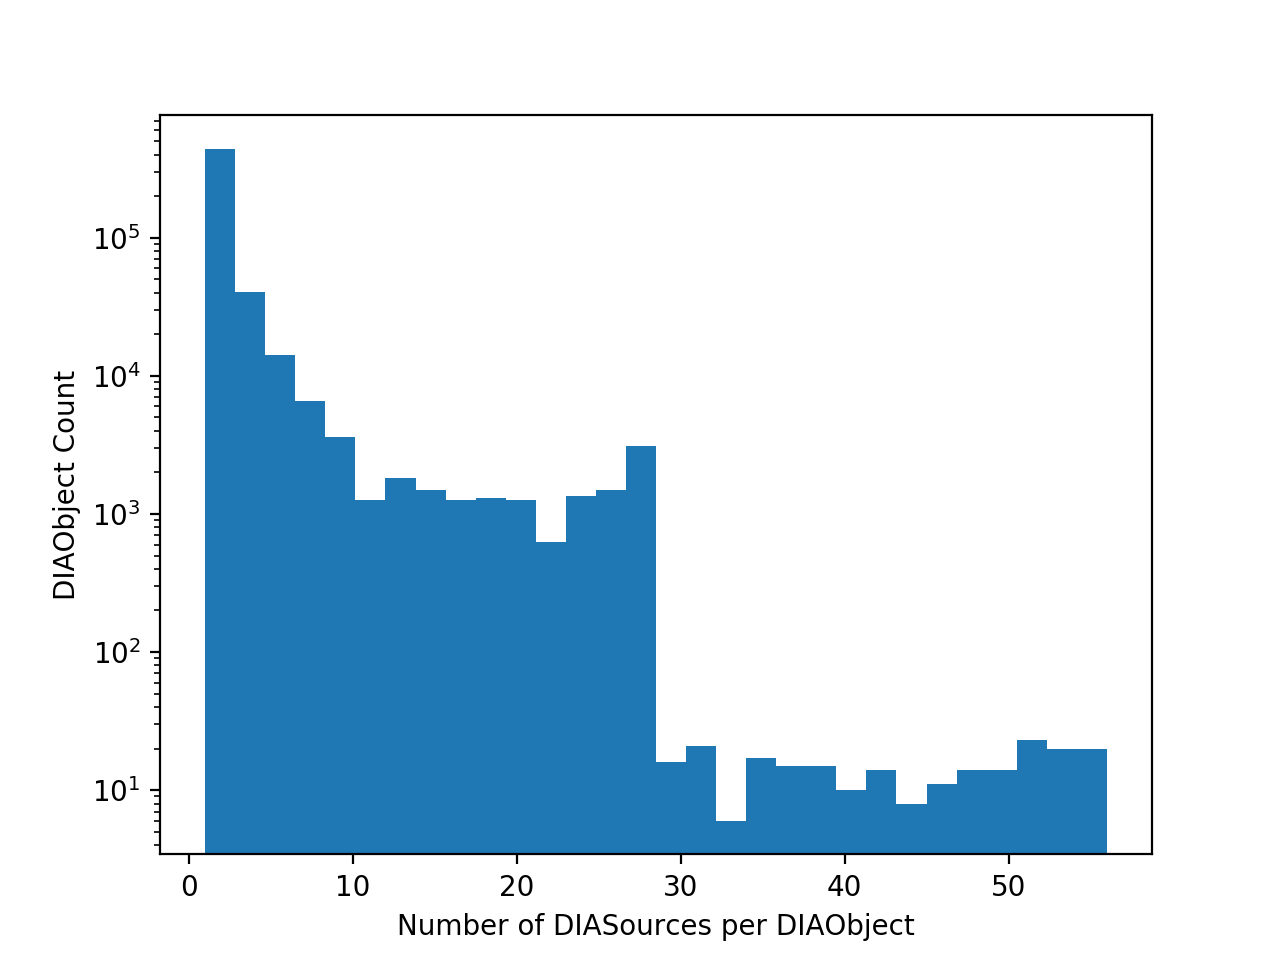

In [4]:
count = objTableOrig['nDiaSources'].values
plt.figure()
plt.hist(count, bins=30)
plt.yscale('log')
plt.xlabel('Number of DIASources per DIAObject')
plt.ylabel('DIAObject Count')

<IPython.core.display.Javascript object>


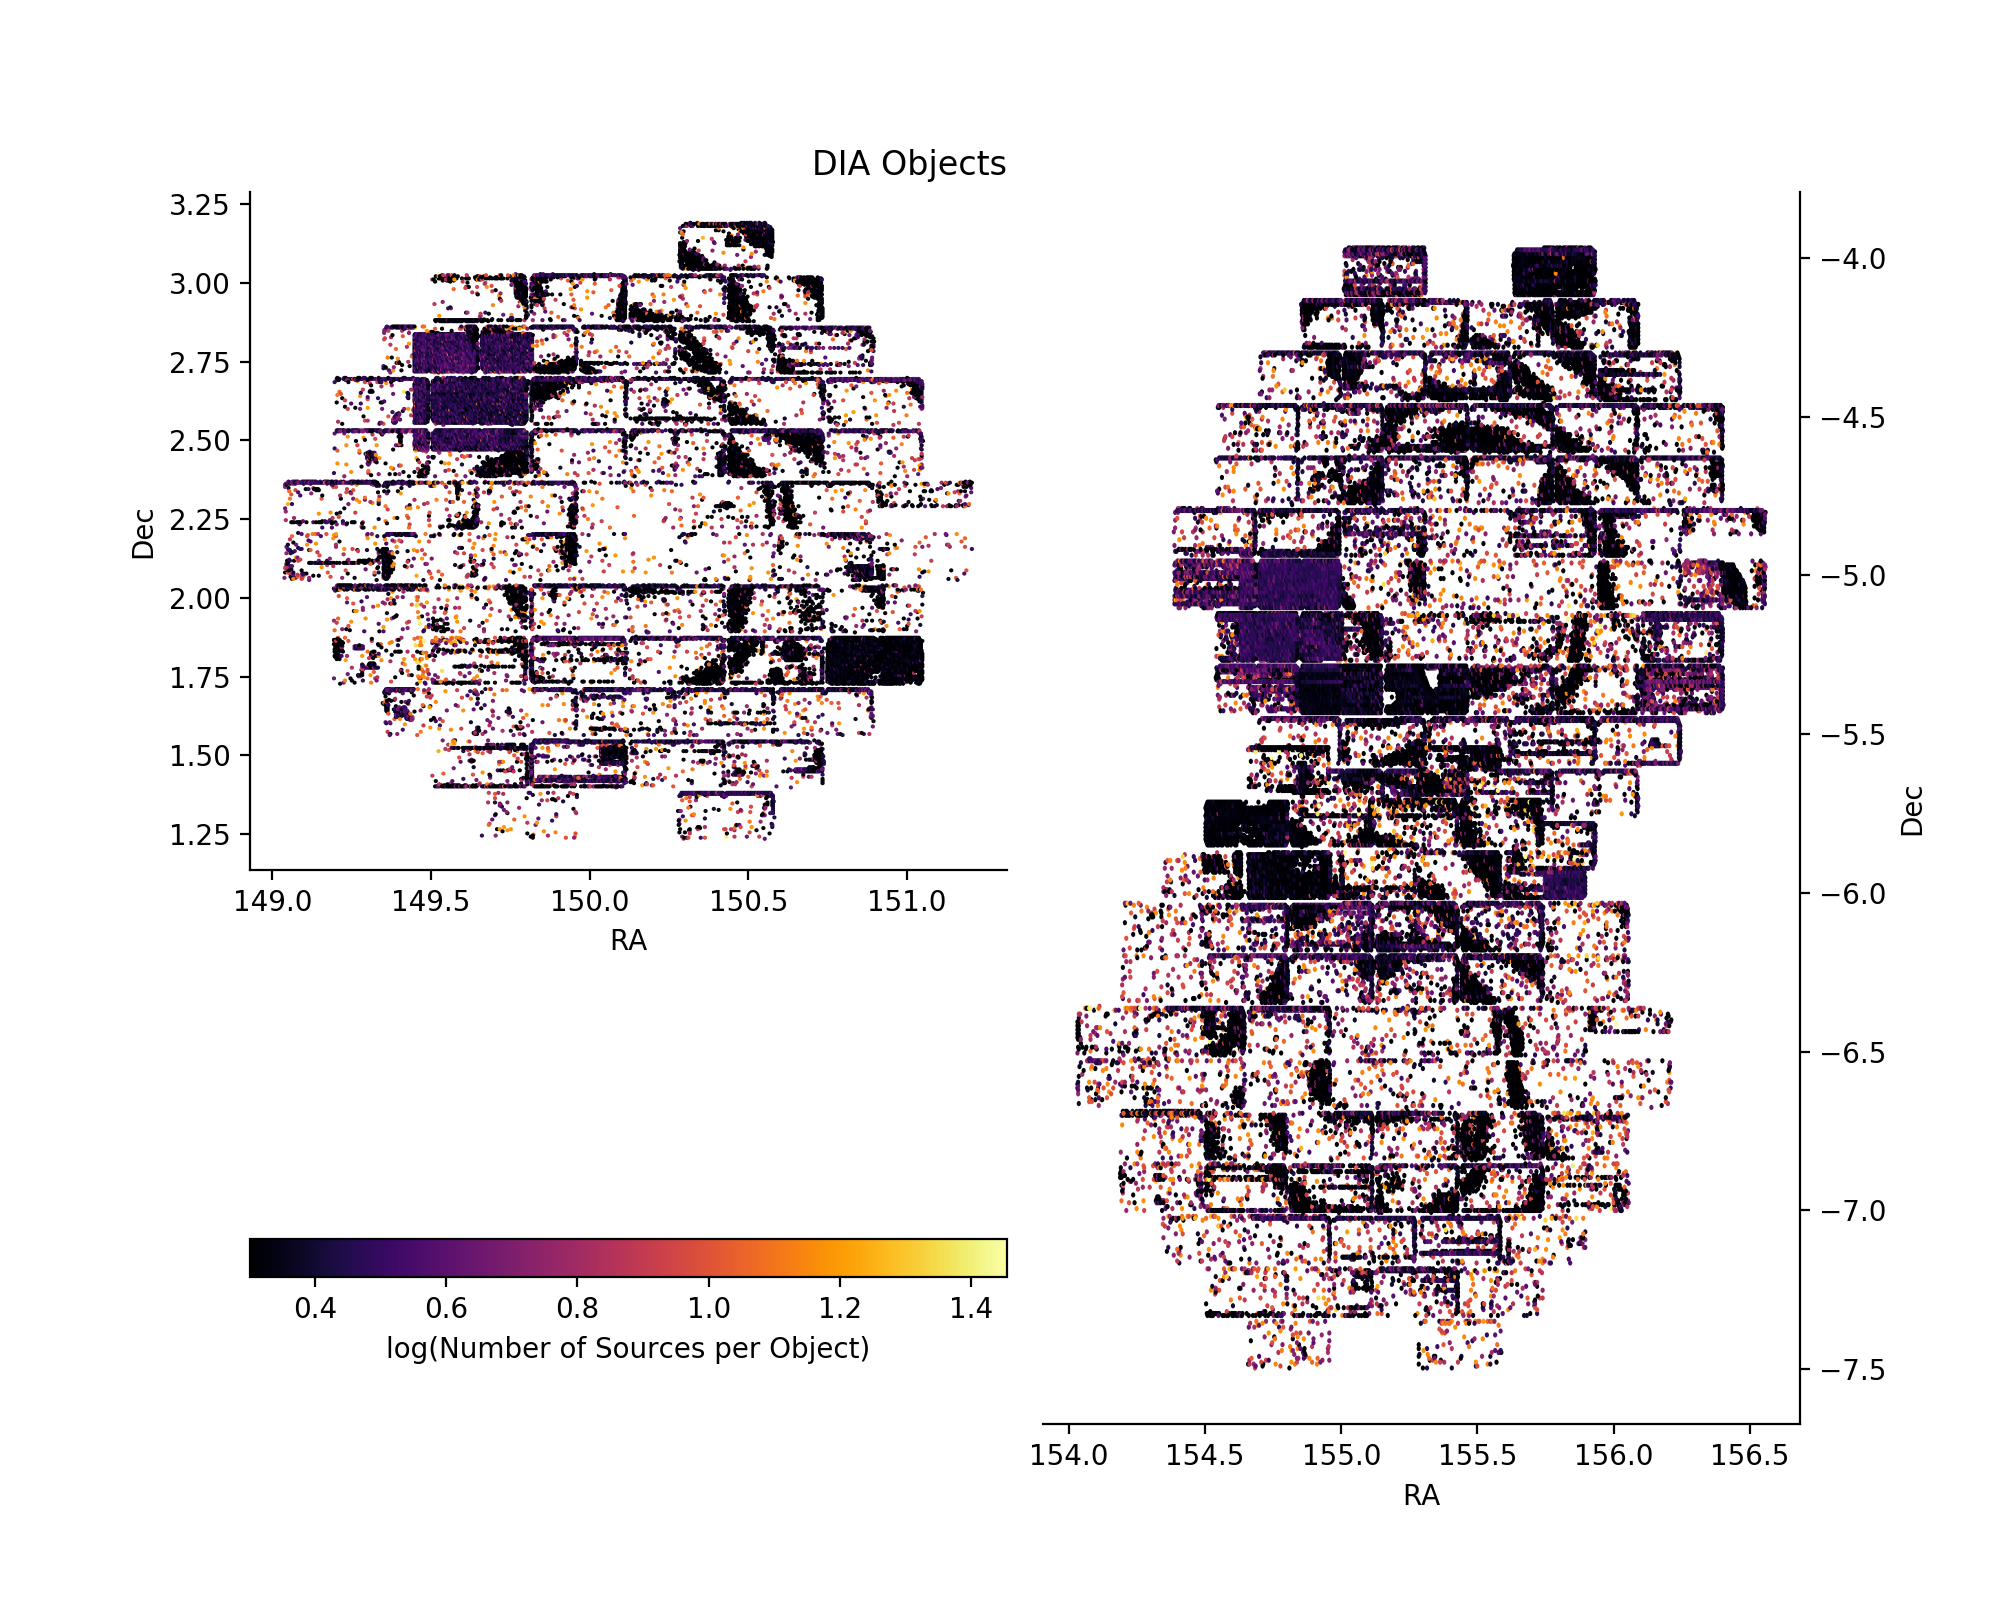

In [5]:
# Make two "subsets" of sources on the sky, with a declination cut
dec_set1 = (objTableOrig['coord_dec'] > -2)
dec_set2 = ~dec_set1

src_count1 = objTableOrig.loc[dec_set1, 'nDiaSources']
src_count2 = objTableOrig.loc[dec_set2, 'nDiaSources']

fig = plt.figure(facecolor='white', figsize=(10,8))
plt.subplots_adjust(wspace=0.1, hspace=0)

# Panel 1: one HiTS field
ax1 = plt.subplot2grid((4,4), (0,0), rowspan=4, colspan=2)
ax1.set_facecolor('white')
plot1 = plt.hexbin(objTableOrig.loc[dec_set1, 'coord_ra'], objTableOrig.loc[dec_set1, 'coord_dec'], C=src_count1,
                   cmap='inferno', bins='log', gridsize=500, mincnt=1)
plt.title('DIA Objects', loc='right')
plt.xlabel('RA')
plt.ylabel('Dec')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
cb = fig.colorbar(plot1, orientation='horizontal', pad=0.3)
cb.set_label('log(Number of Sources per Object)')

# Panel 2: two (overlapping) HiTS fields
ax2 = plt.subplot2grid((4,4), (0,2), rowspan=4, colspan=2)
ax2.set_facecolor('white')
plot2 = plt.hexbin(objTableOrig.loc[dec_set2, 'coord_ra'], objTableOrig.loc[dec_set2, 'coord_dec'], C=src_count2,
                   cmap='inferno', bins='log', gridsize=500, mincnt=1)
plt.xlabel('RA')
plt.ylabel('Dec')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

In [6]:
newname1 = {'id': 'diaSourceId'}
srcTableOrig.rename(index=str, columns=newname1, inplace=True)

newname2 = {'id': 'diaObjectId'}
objTableOrig.rename(index=str, columns=newname2, inplace=True)

superTable = objTableOrig.merge(srcTableOrig[['psFlux', 'psFluxErr', 'ccdVisitId', 'diaObjectId']], on='diaObjectId')
superTimeTable = superTable.merge(ccdTableOrig[['ccdVisitId', 'expMidptMJD']], on='ccdVisitId')
superTimeTable.sort_values('diaObjectId', inplace=True)

<IPython.core.display.Javascript object>


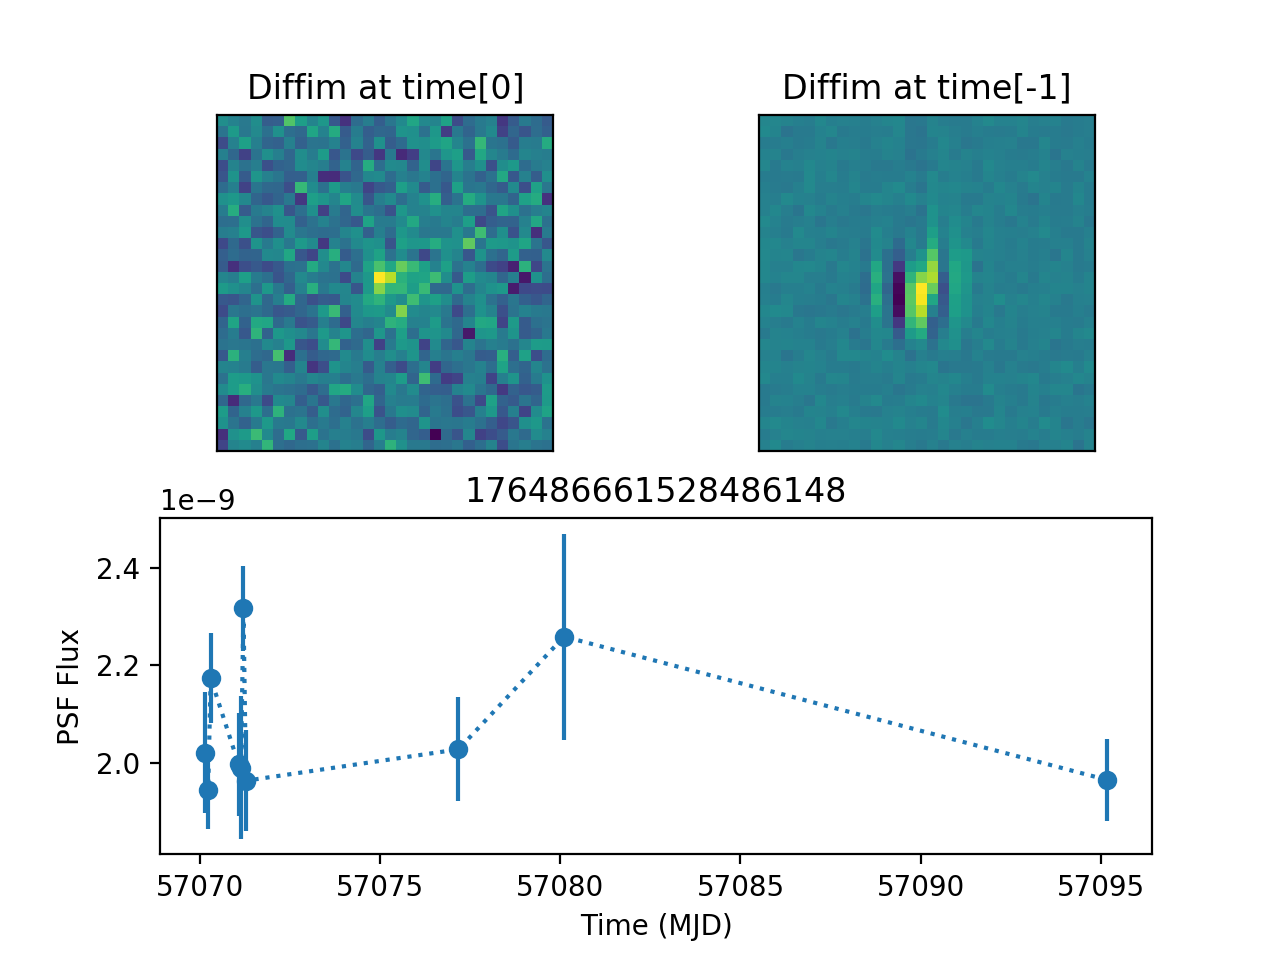

<IPython.core.display.Javascript object>


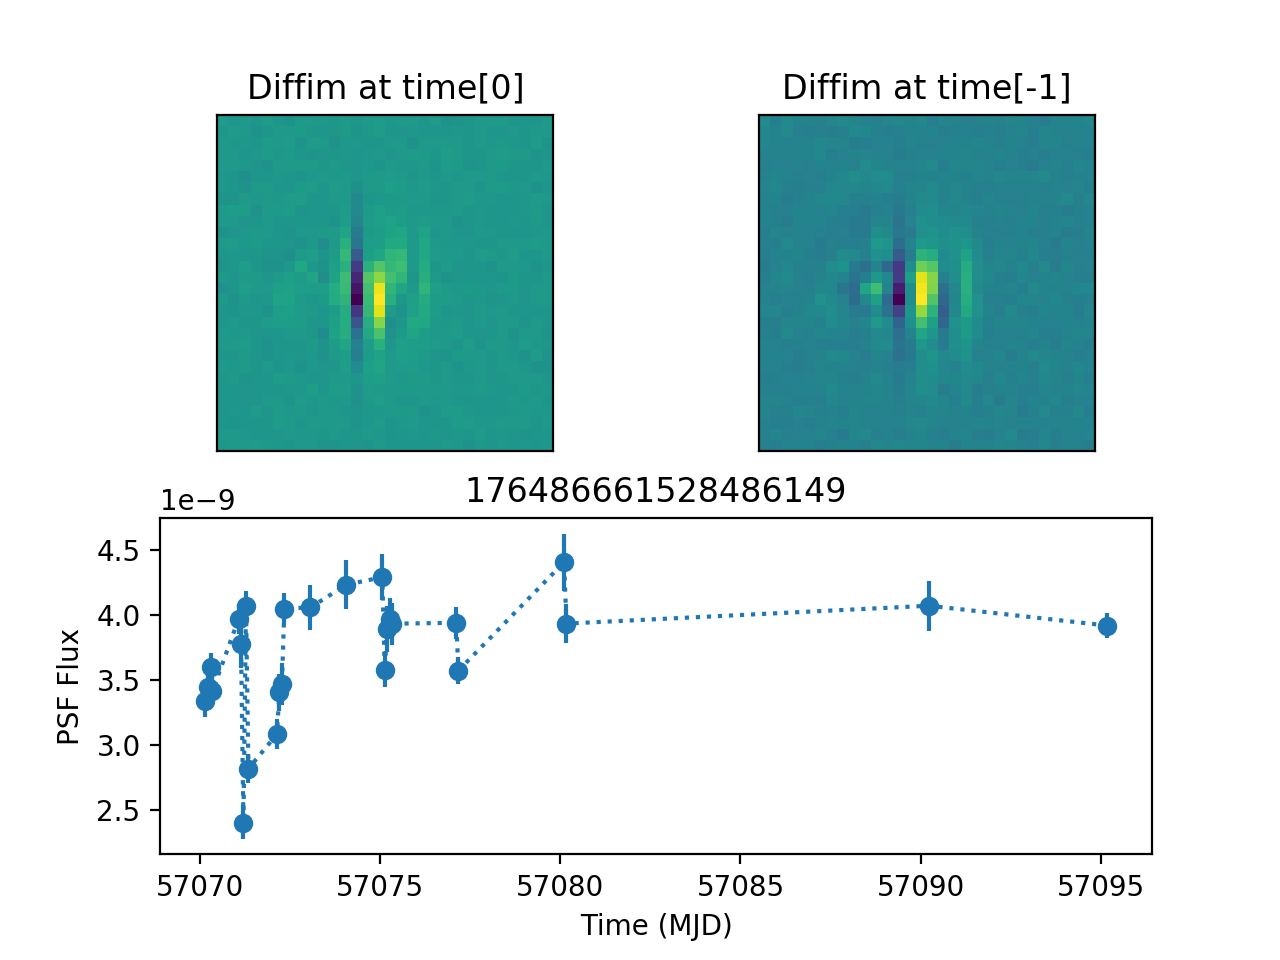

<IPython.core.display.Javascript object>


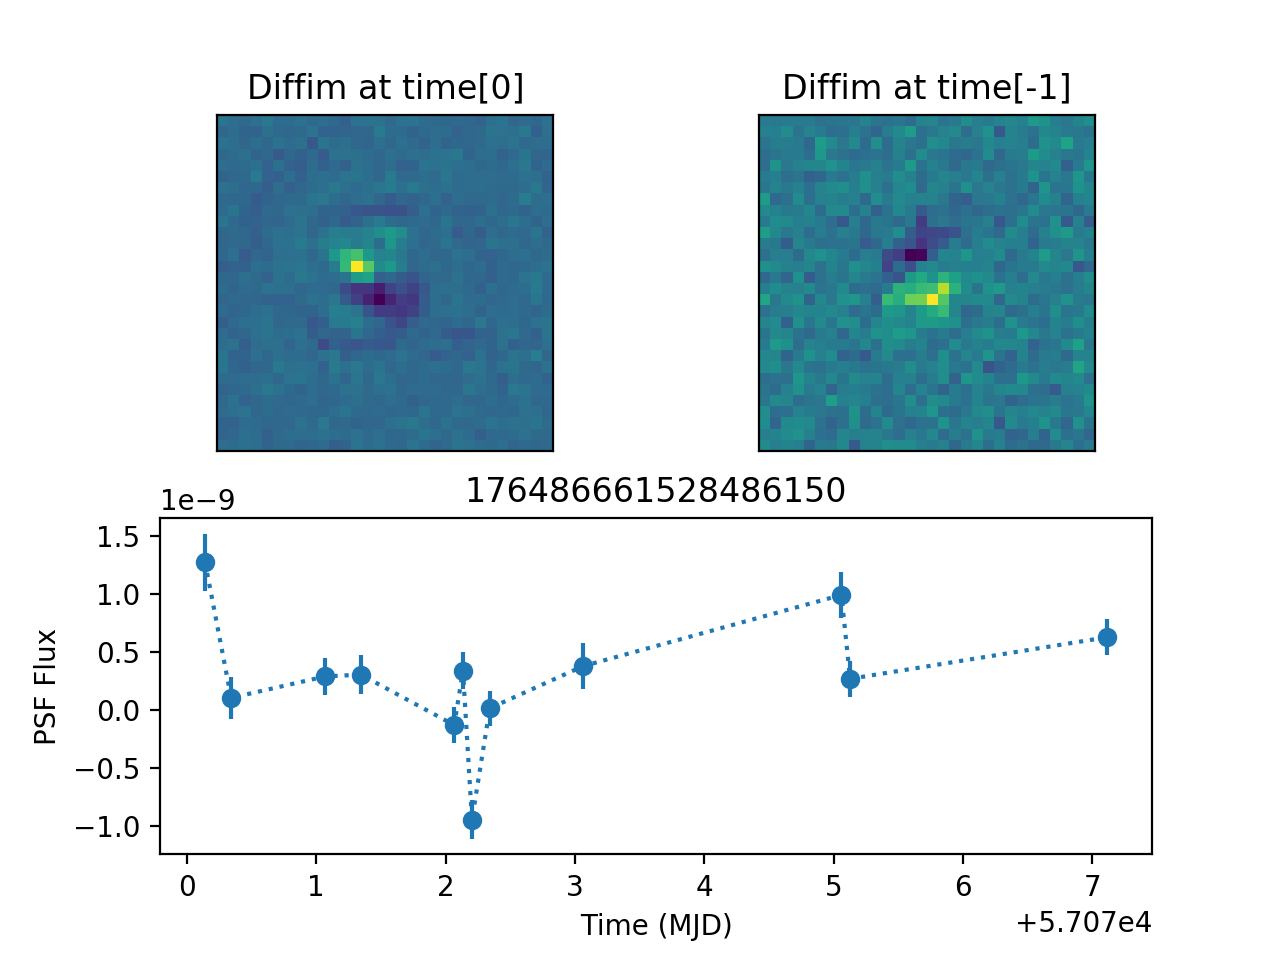

<IPython.core.display.Javascript object>


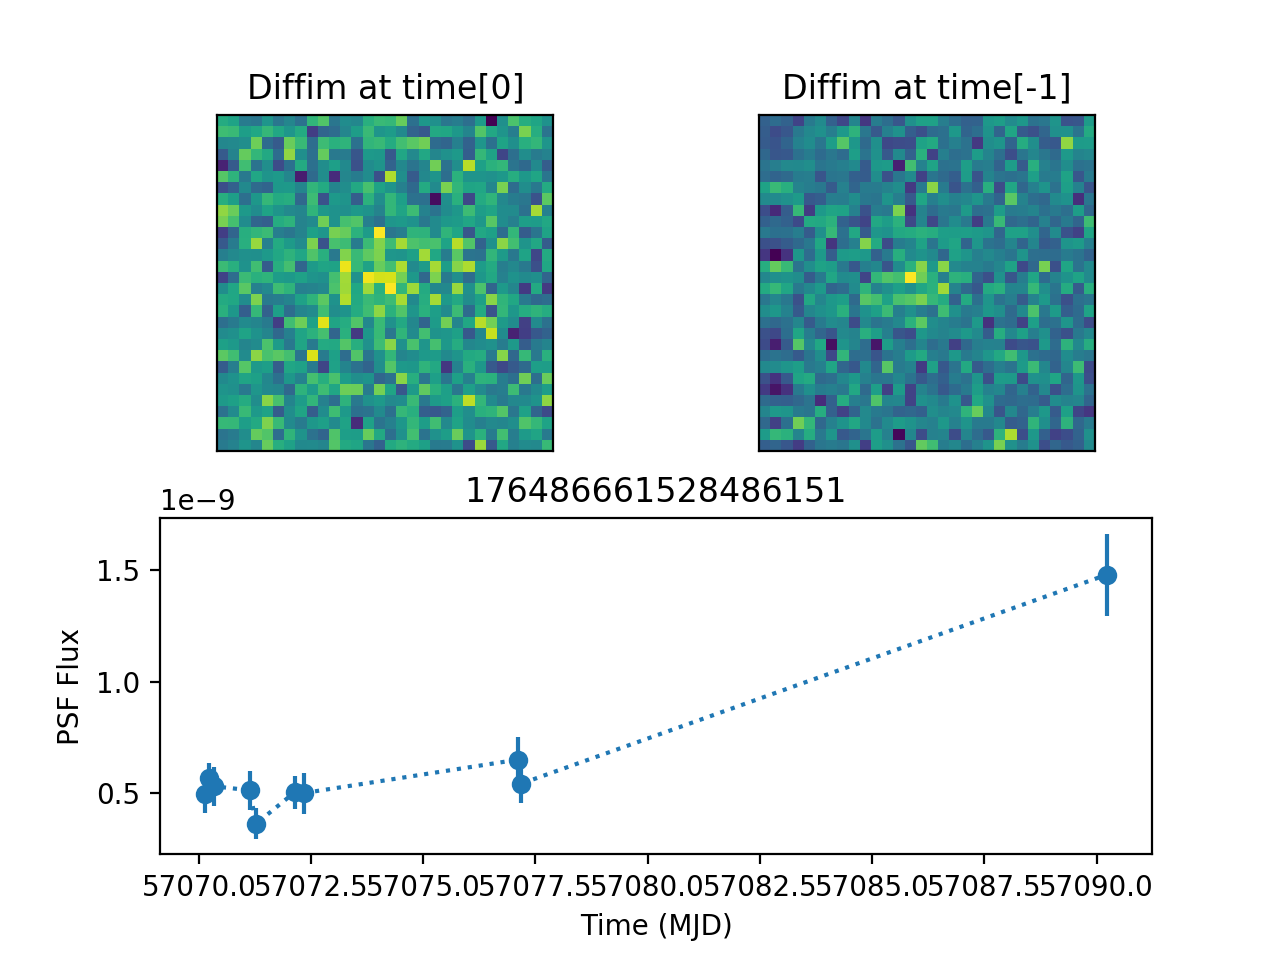

<IPython.core.display.Javascript object>


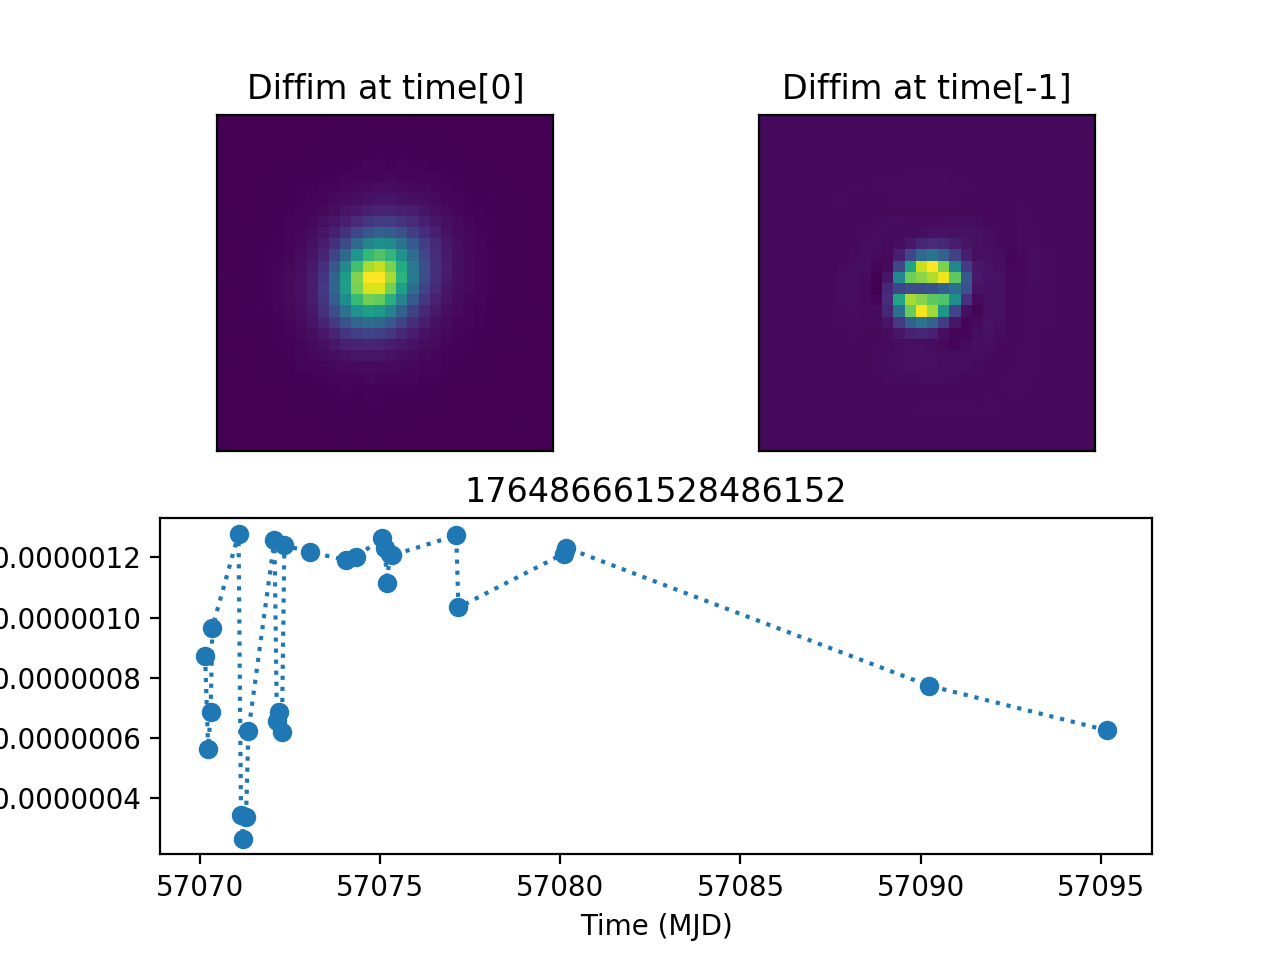

<IPython.core.display.Javascript object>


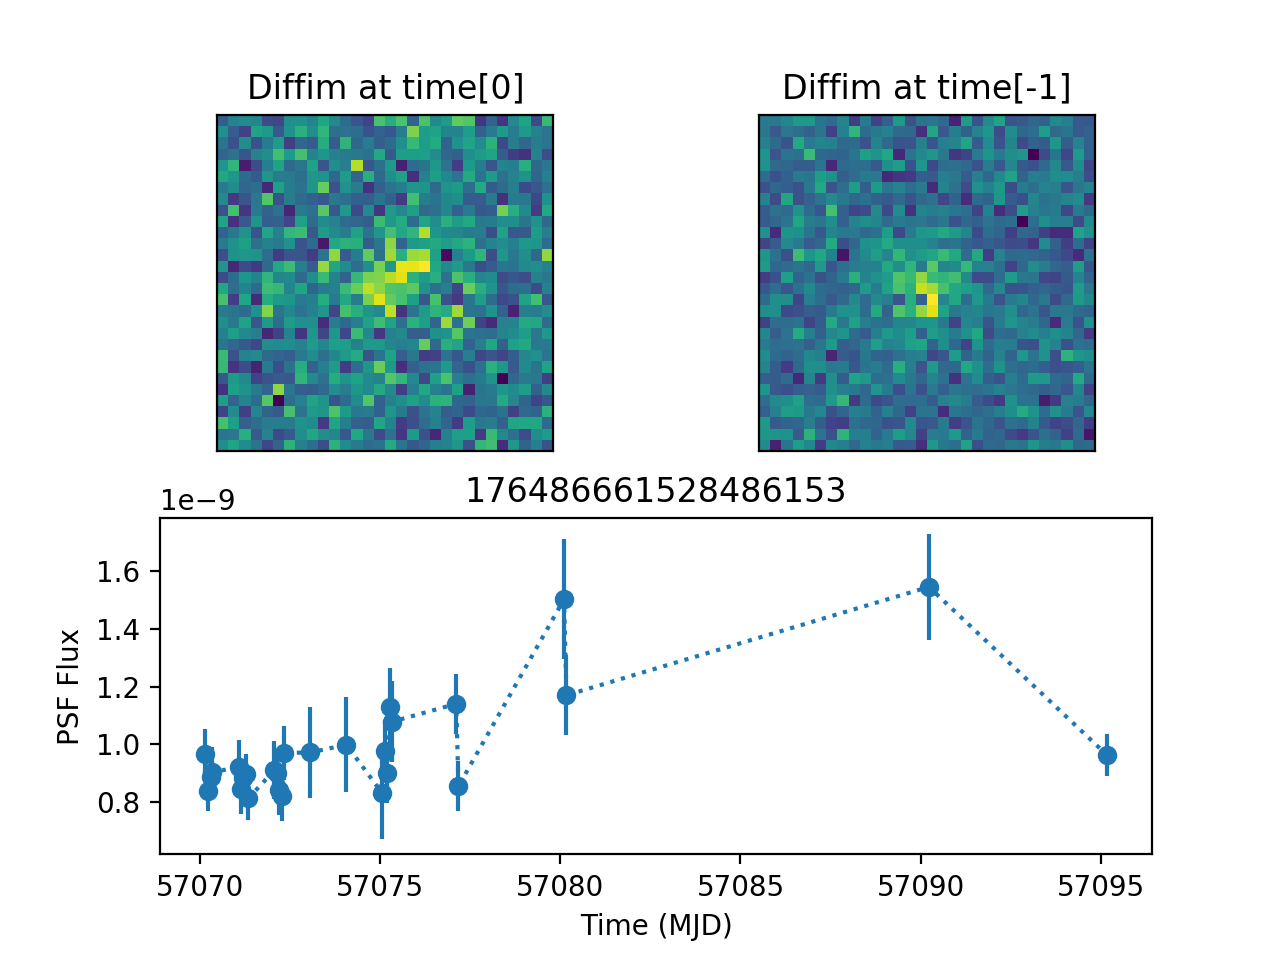

<IPython.core.display.Javascript object>


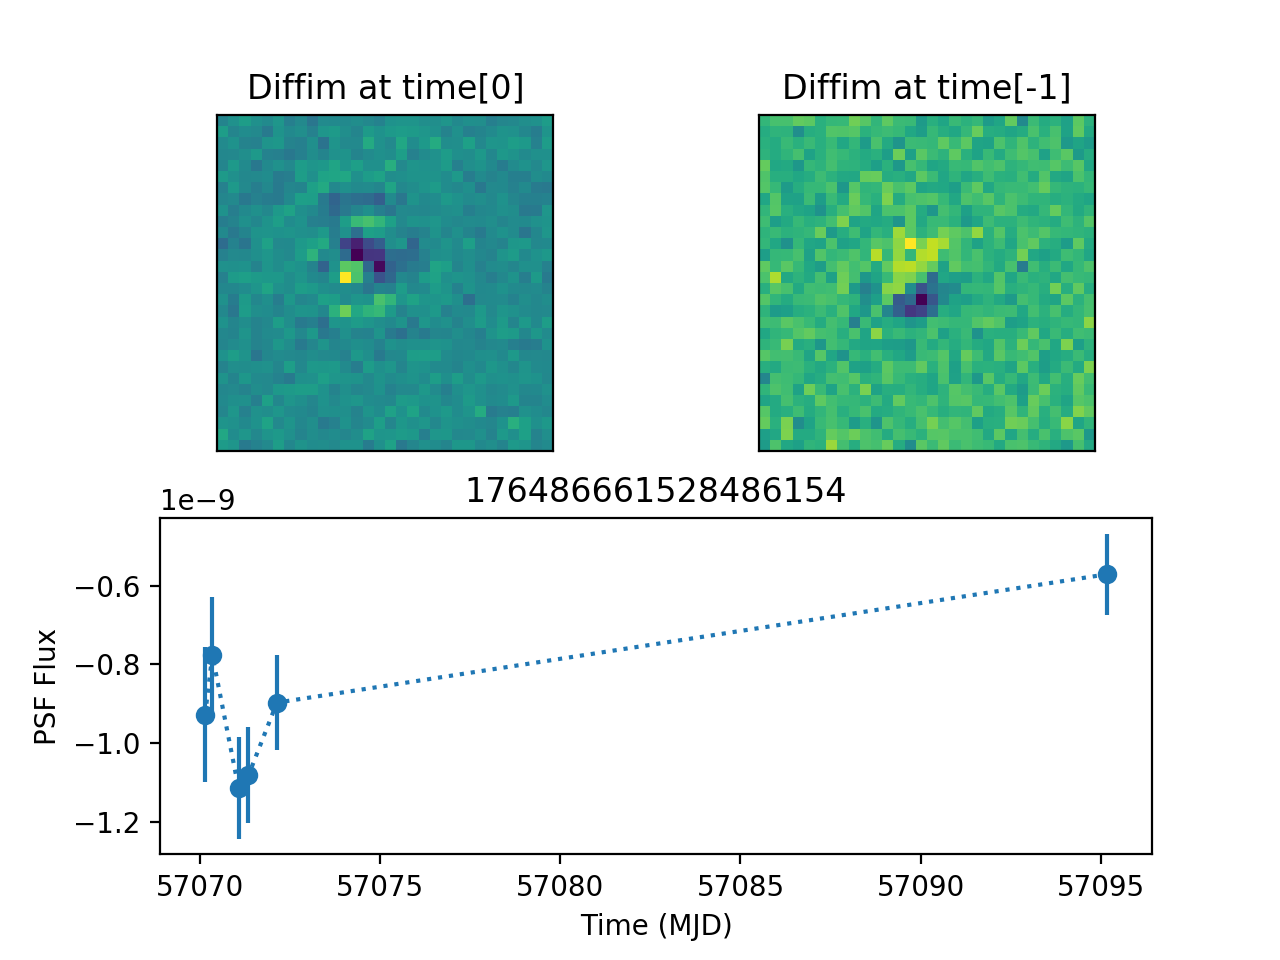

<IPython.core.display.Javascript object>


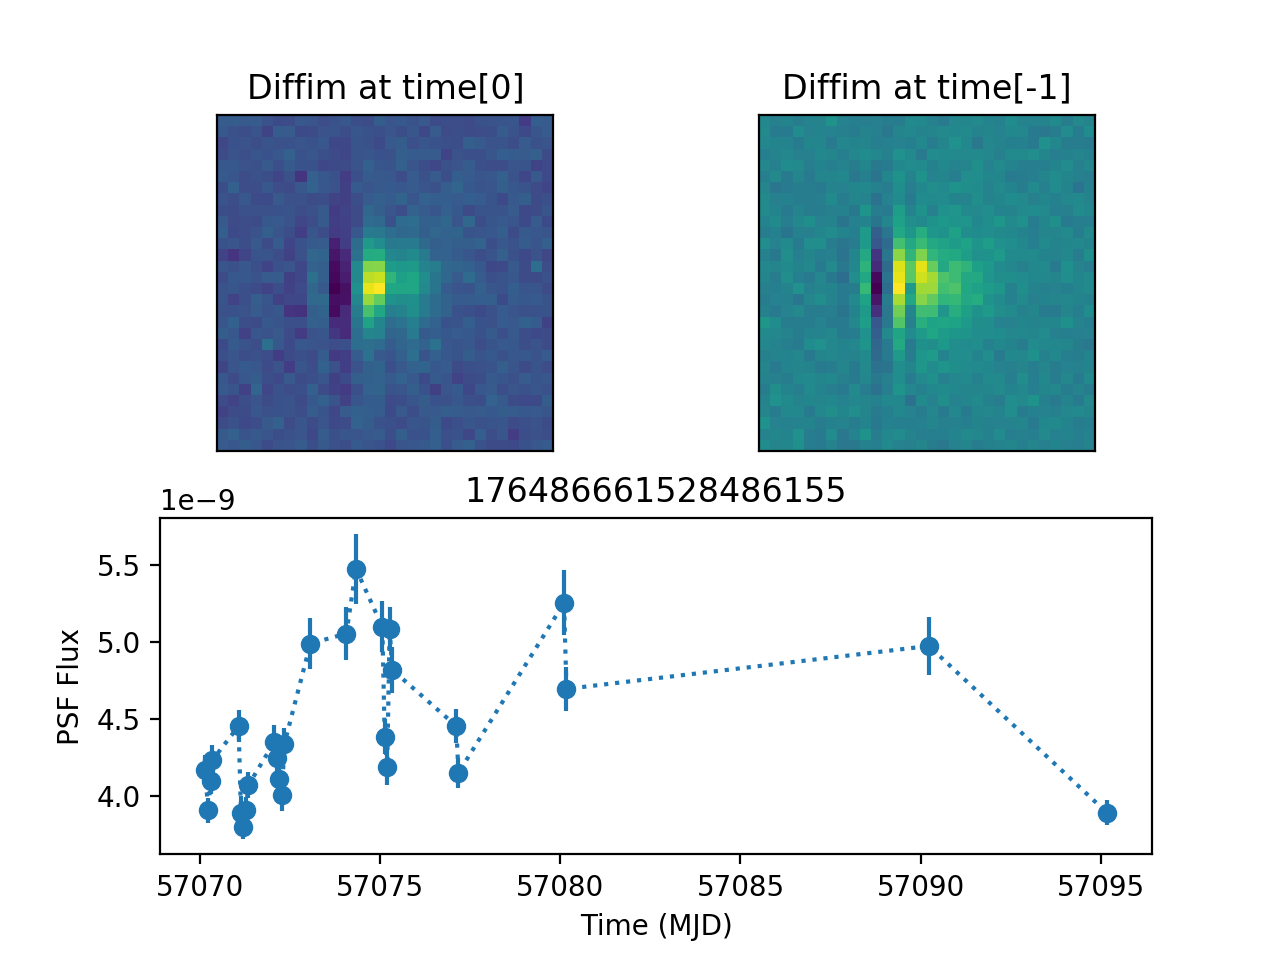

<IPython.core.display.Javascript object>


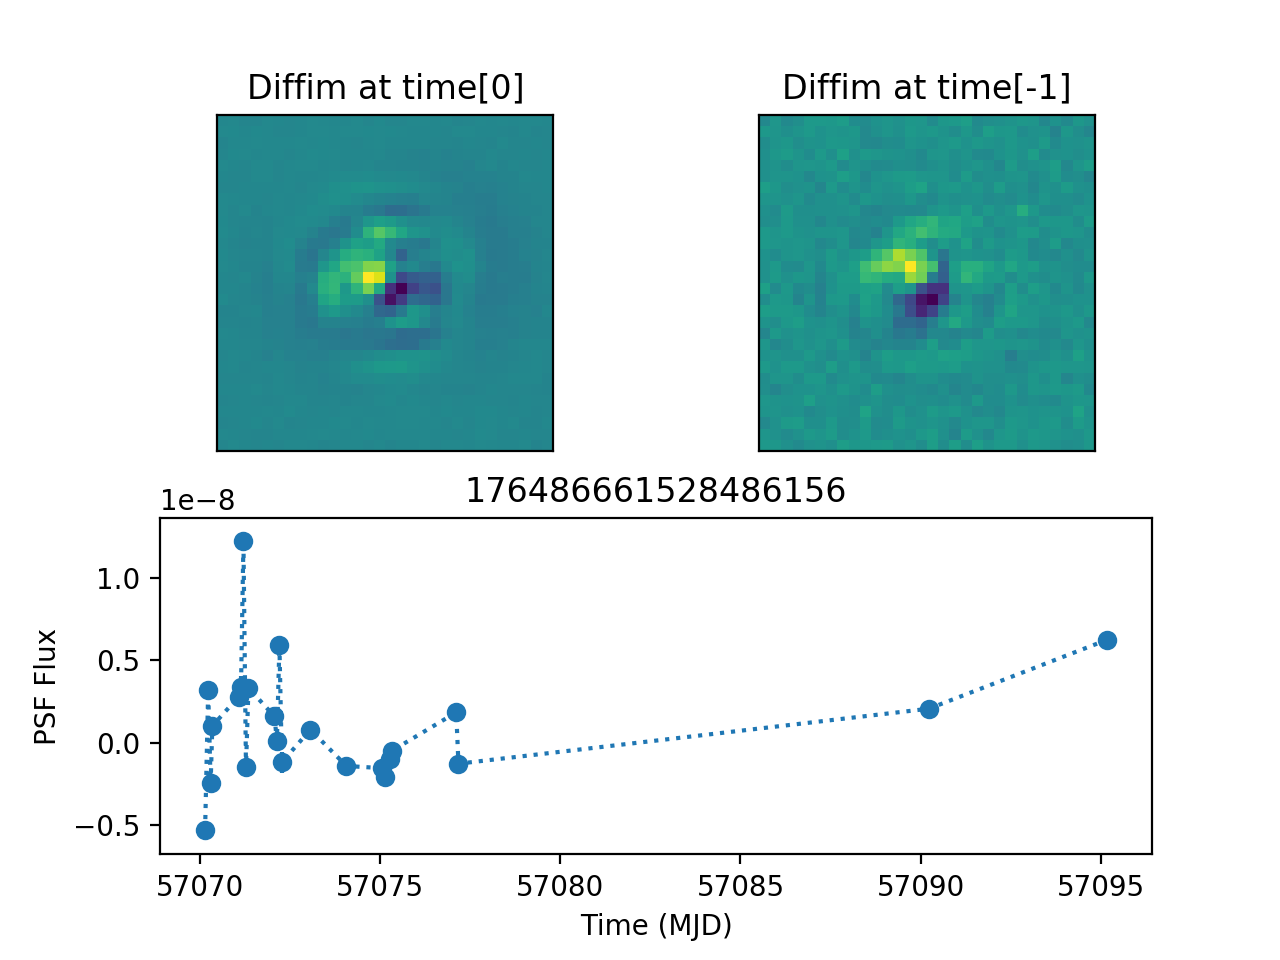

<IPython.core.display.Javascript object>


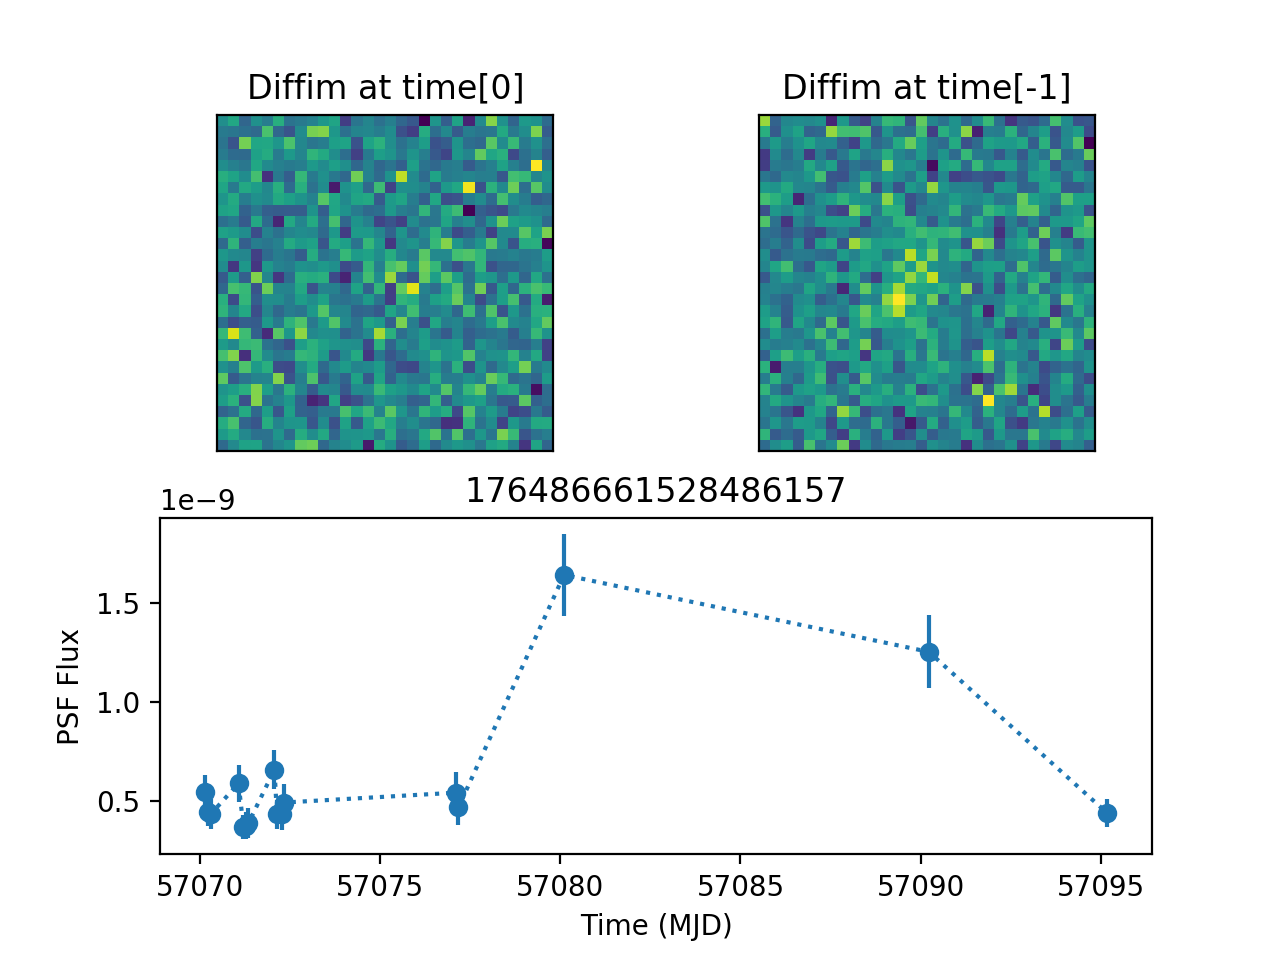

<IPython.core.display.Javascript object>


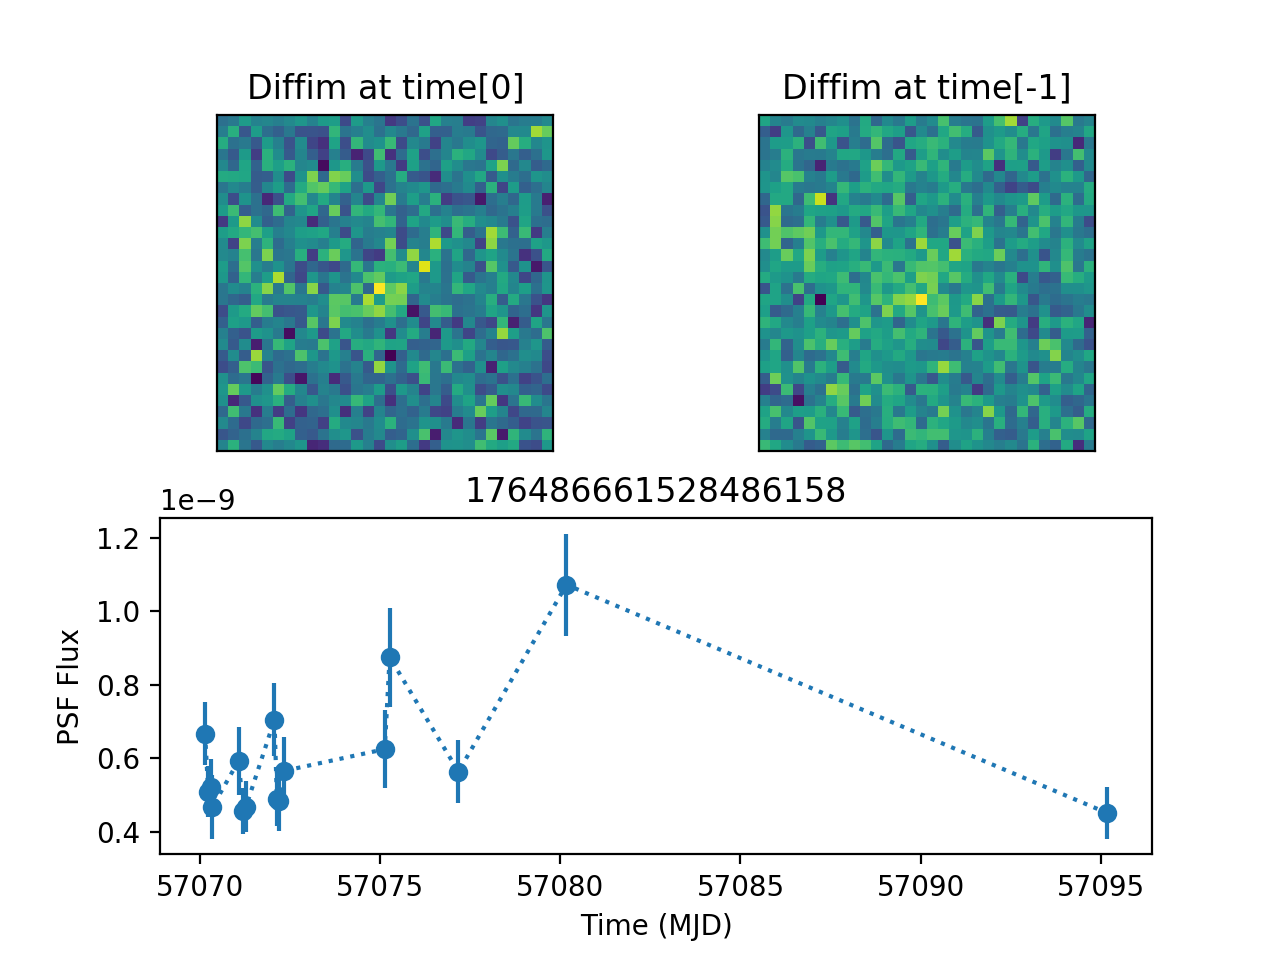

<IPython.core.display.Javascript object>


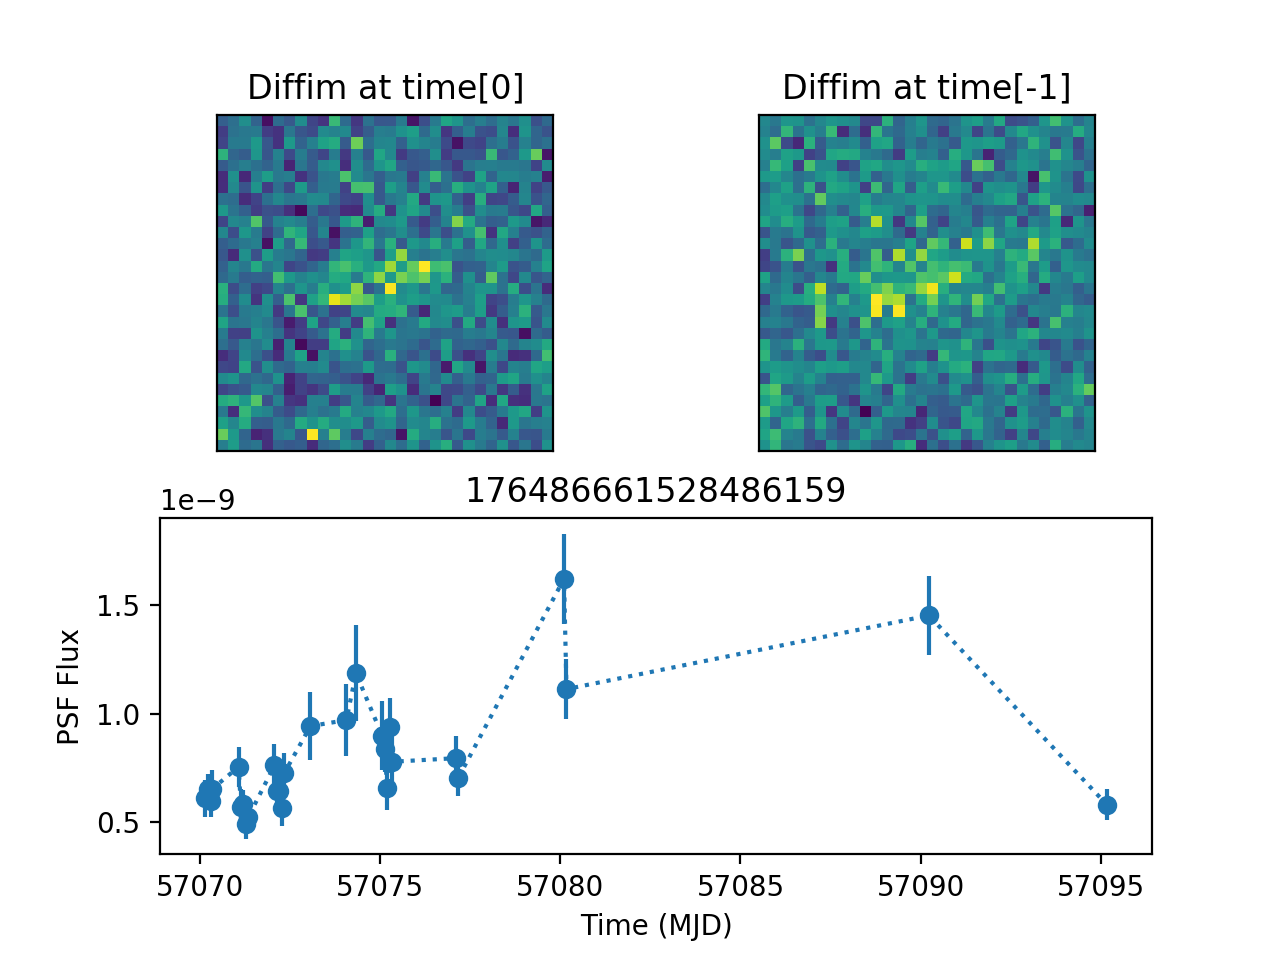

<IPython.core.display.Javascript object>


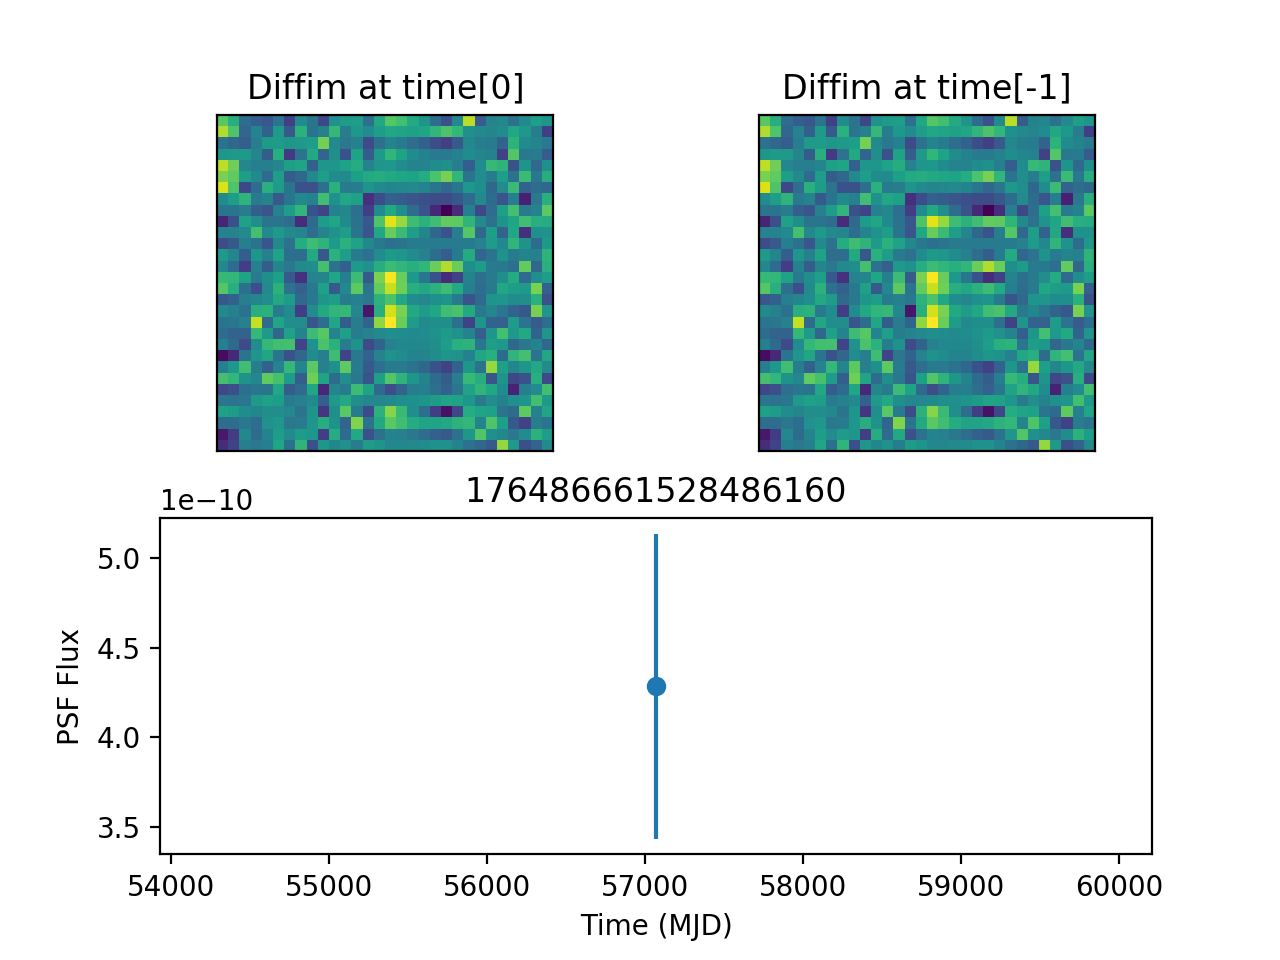

<IPython.core.display.Javascript object>


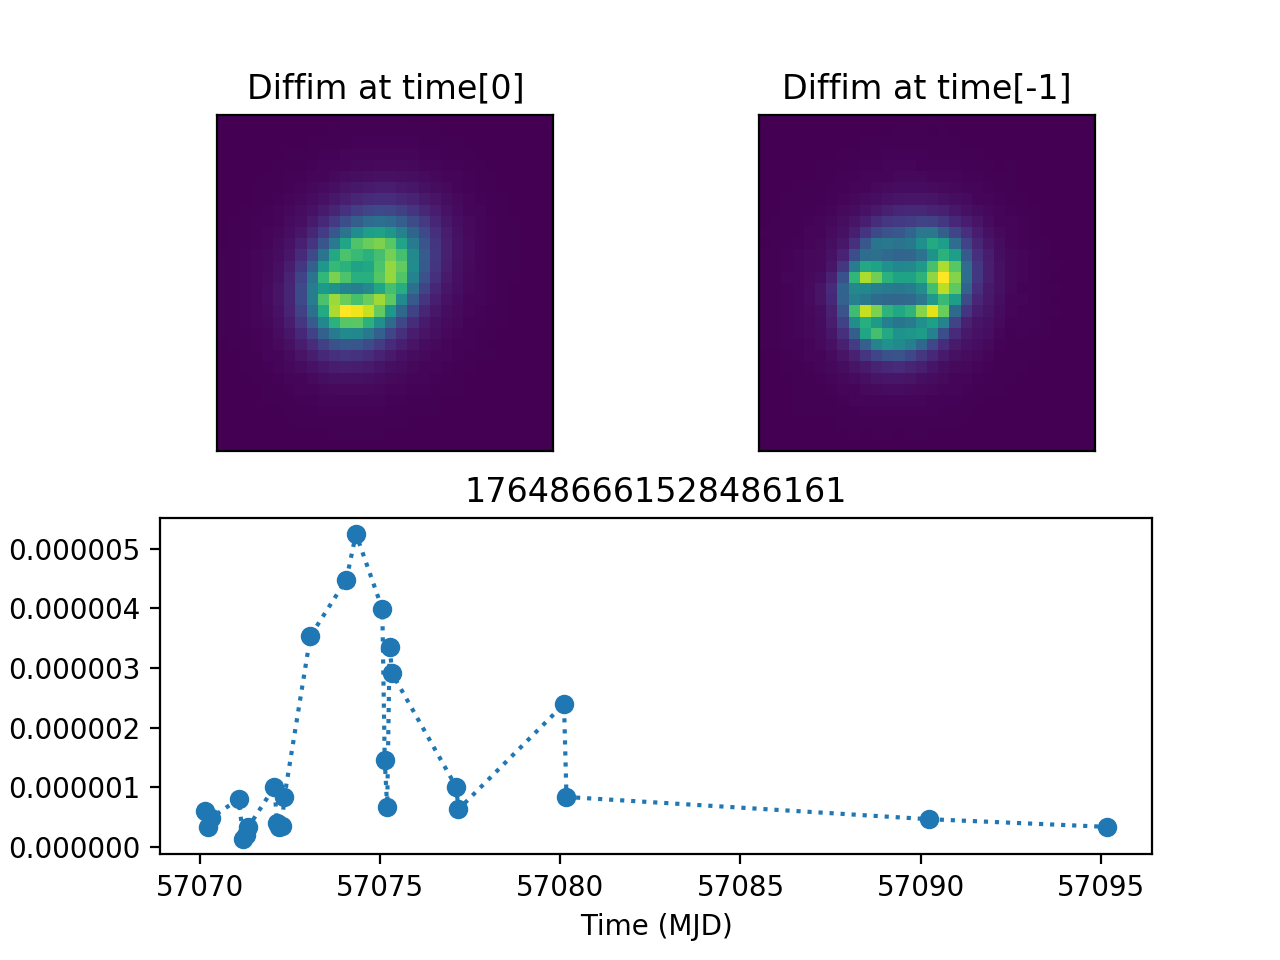

<IPython.core.display.Javascript object>


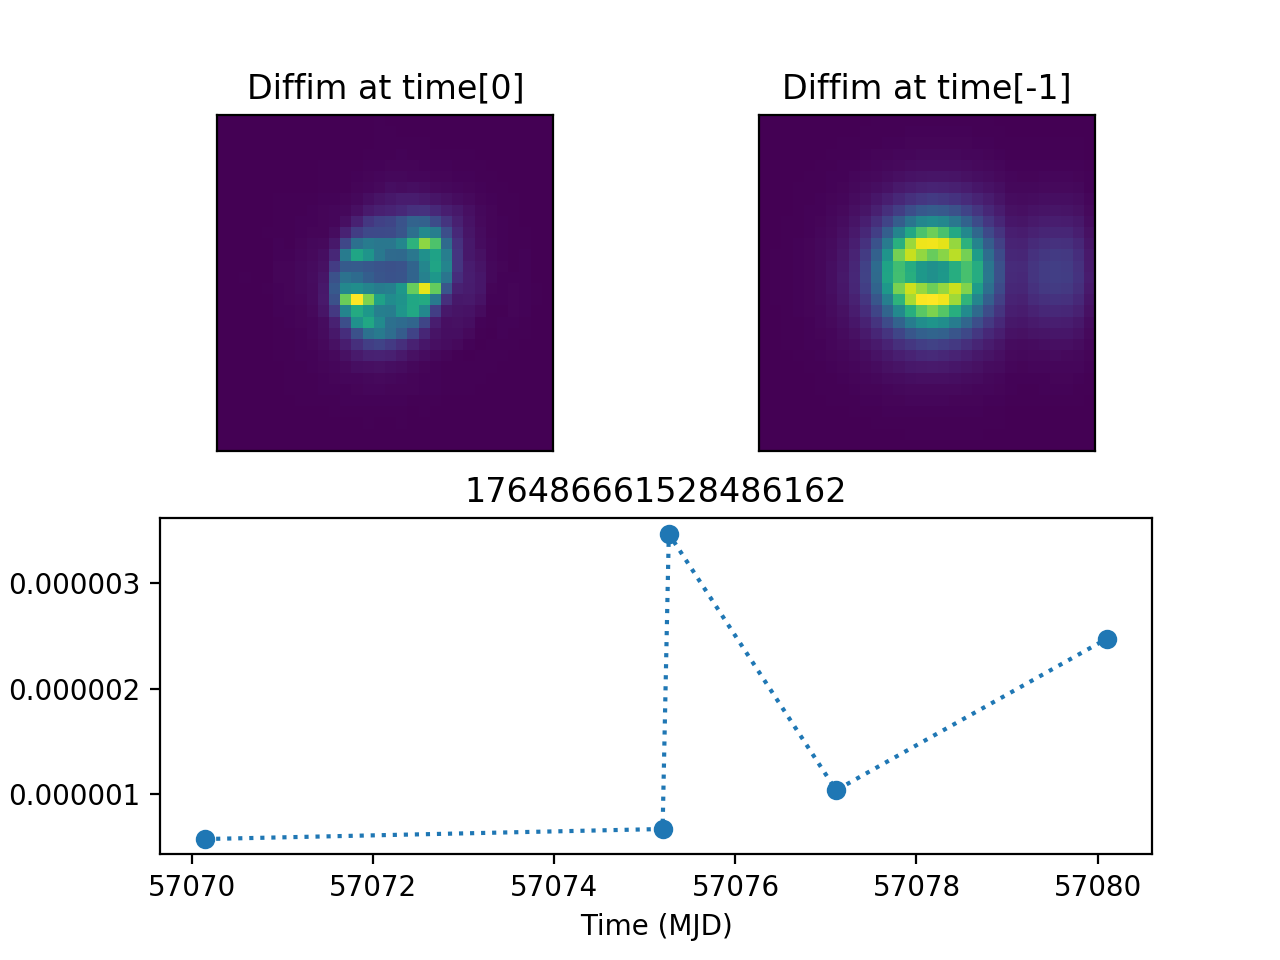

<IPython.core.display.Javascript object>


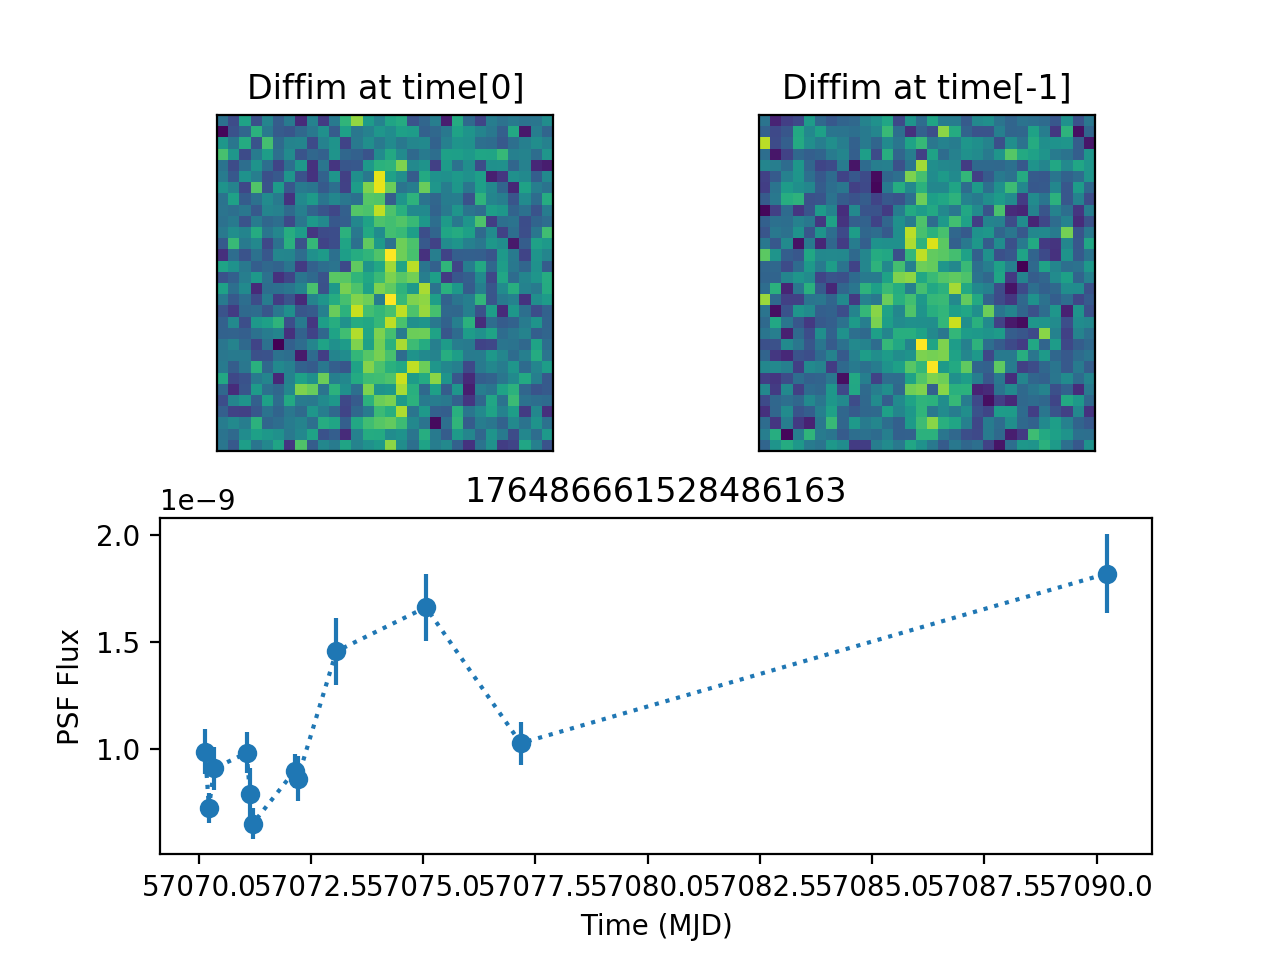

<IPython.core.display.Javascript object>


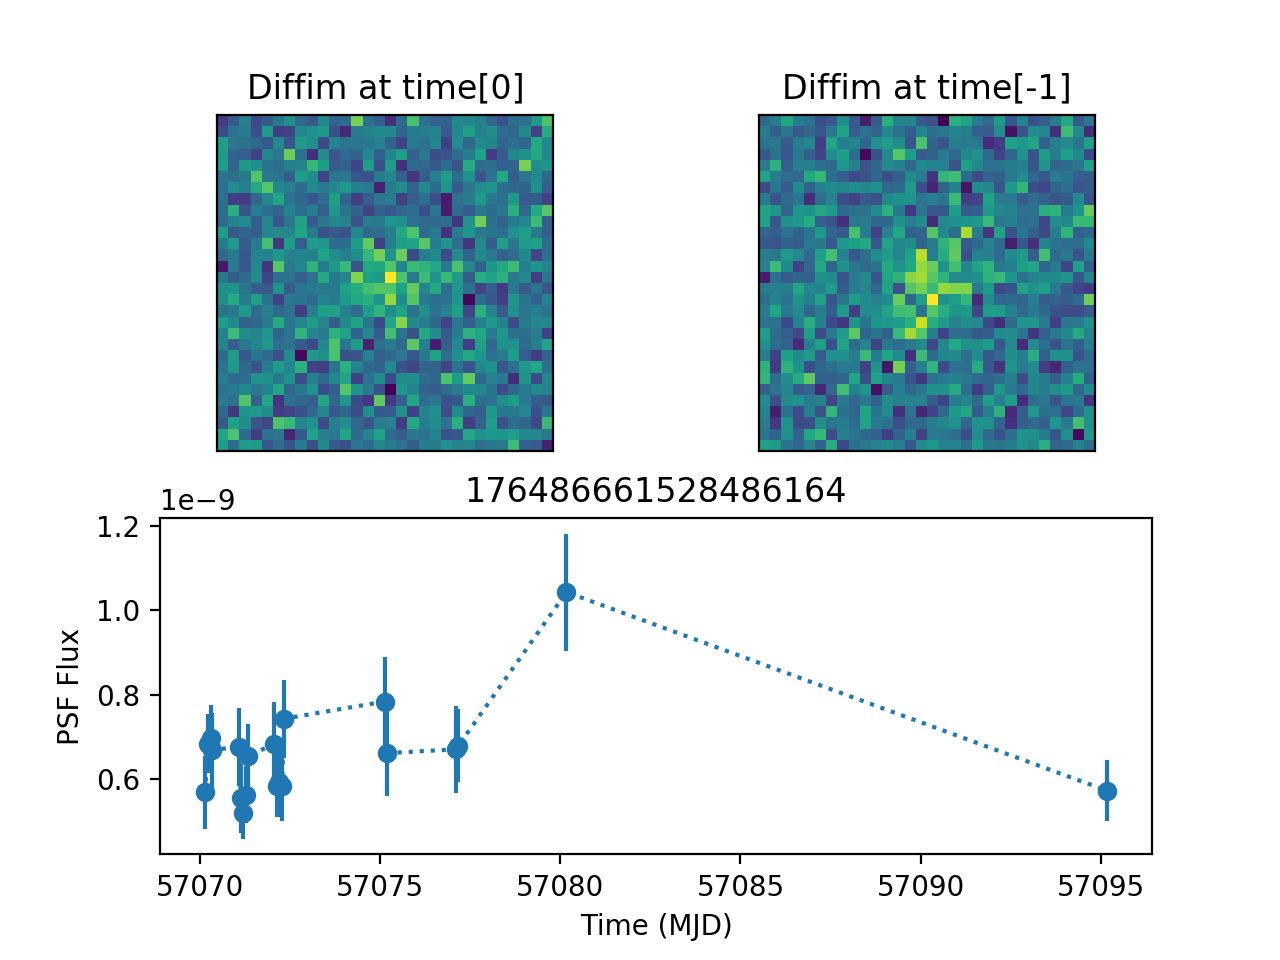

<IPython.core.display.Javascript object>


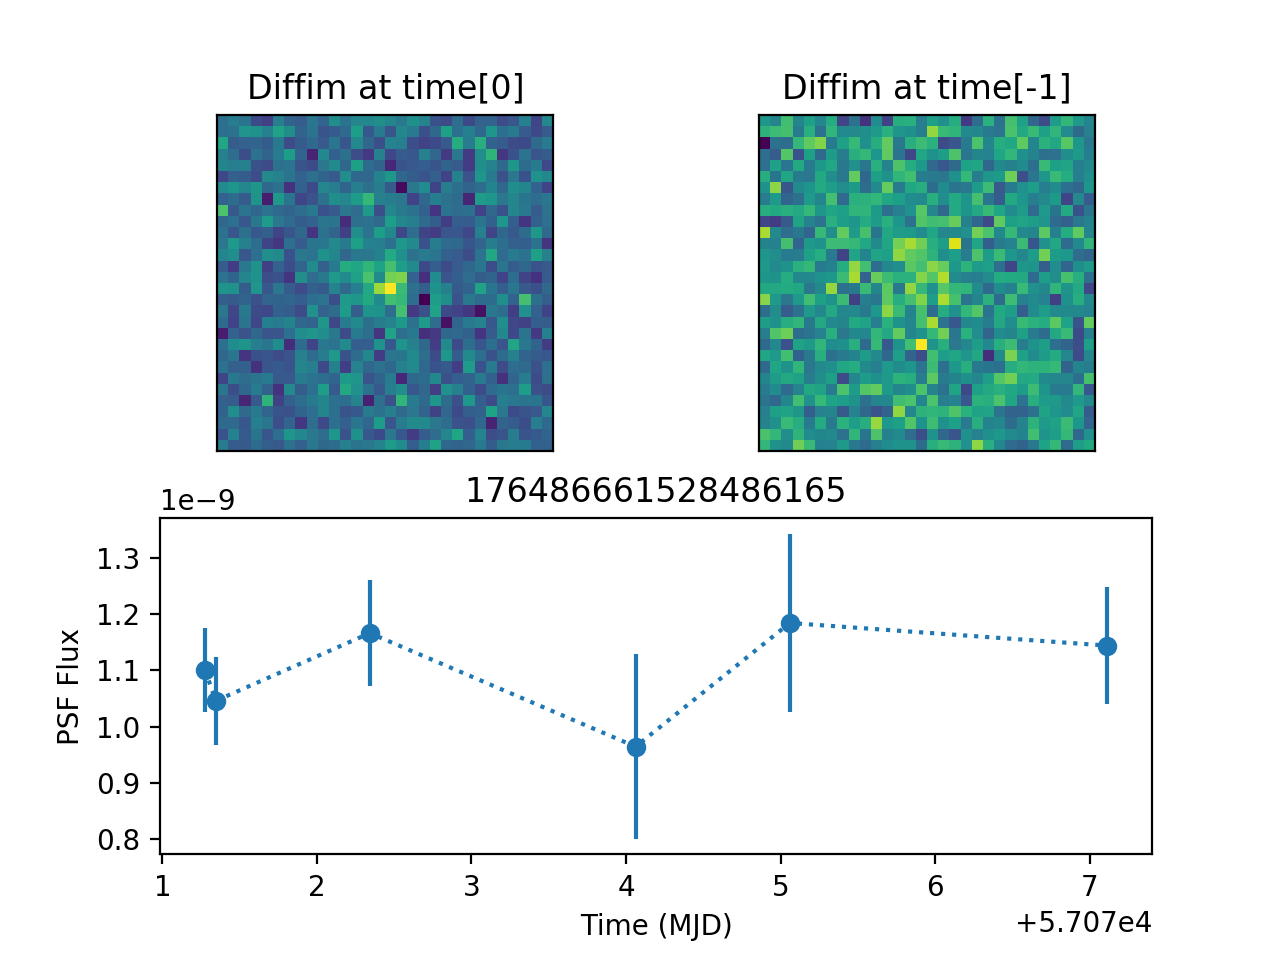

In [8]:
objGroup = superTimeTable[900:1200].groupby('diaObjectId')
for obj, group in objGroup:
    ra = group['coord_ra'].values[0]
    dec = group['coord_dec'].values[0]
    plt.figure()
    plt.subplot(212)
    times = group['expMidptMJD'].values
    astropy_times = Time(times, format='mjd')
    sortidx = astropy_times.argsort()
    astropy_times = astropy_times[sortidx]
    #print(astropy_times.sort())  # equivalent, but no good for parallel arrays
    fluxes = group['psFlux'].values[sortidx]
    fluxerrs = group['psFluxErr'].values[sortidx]
    plt.errorbar(astropy_times.mjd, fluxes, yerr=fluxerrs, ls=':', marker='o')
    plt.title(obj)
    plt.xlabel('Time (MJD)')
    plt.ylabel('PSF Flux')
    # cutout at time[0]
    plt.subplot(221)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.title('Diffim at time[0]')
    dataId = group['ccdVisitId'].values
    visit_first = int(str(dataId[0])[0:6])
    visit_last = int(str(dataId[-1])[0:6])
    ccdnum = int(str(dataId[0])[6:])
    dataIdDictFirst = {'visit': visit_first, 'ccdnum': ccdnum}
    dataIdDictLast = {'visit': visit_last, 'ccdnum': ccdnum}
    imageFirst = butler.get('deepDiff_differenceExp', dataIdDictFirst)
    centerSource = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
    size = lsst.geom.Extent2I(30, 30)
    cutoutFirst = imageFirst.getCutout(centerSource, size)
    plt.imshow(cutoutFirst.getMaskedImage().getImage().getArray())
    # cutout at time[-1]
    plt.subplot(222)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.title('Diffim at time[-1]')
    imageLast = butler.get('deepDiff_differenceExp', dataIdDictLast)
    cutoutLast = imageLast.getCutout(centerSource, size)
    plt.imshow(cutoutLast.getMaskedImage().getImage().getArray())